<a href="https://colab.research.google.com/github/mAminl/HWs/blob/master/HW2Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Full Name: MohammadAmin Latifi

Student Number: 401300966

HW 2, Question 1: 

Part a)

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

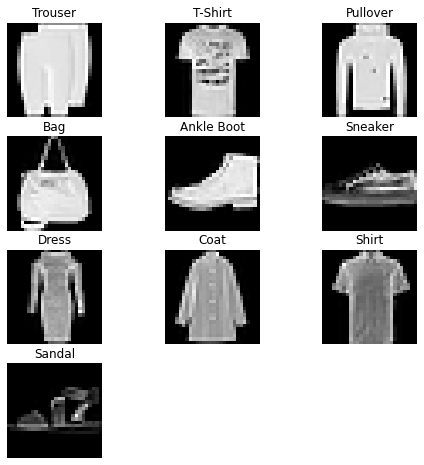

In [2]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 4
unique_labels = []
k = 1
while len(unique_labels) < len(labels_map):
    length = len(unique_labels)
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    unique_labels.append(labels_map[label]) if labels_map[label] not in unique_labels else unique_labels
    if (len(unique_labels) > length):
      figure.add_subplot(rows, cols, k)
      plt.title(labels_map[label])
      plt.axis("off")
      plt.imshow(img.squeeze(), cmap="gray")
      k+=1
plt.show()

Part b)

In [15]:
from torchvision.transforms import ToTensor, Lambda

ds_train = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

ds_test = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

from torch.utils.data import DataLoader
import numpy as np

train_dataloader = DataLoader(ds_train, batch_size=64, shuffle=True)
test_dataloader = DataLoader(ds_test, batch_size=64, shuffle=True)
 
class model():
  def __init__(self):
    self.N = 512
    
    self.W_1 = torch.normal(0,torch.sqrt(torch.tensor(2/(28*28 + self.N))),(28*28,self.N,),requires_grad=True)
    self.b_1 = torch.normal(0,torch.sqrt(torch.tensor(2/(1 + self.N))),(1,self.N),requires_grad=True)
    self.W_2 = torch.normal(0,torch.sqrt(torch.tensor(2/(self.N + self.N))),(self.N,self.N,),requires_grad=True)
    self.b_2 = torch.normal(0,torch.sqrt(torch.tensor(2/(1 + self.N))),(1,self.N),requires_grad=True)
    self.W_3 = torch.normal(0,torch.sqrt(torch.tensor(2/(self.N + self.N))),(self.N,10,),requires_grad=True)
    self.b_3 = torch.normal(0,torch.sqrt(torch.tensor(2/(1 + 10))),(1,10),requires_grad=True)
    self.loss = 0

  def Softmax(self, x):
    maxes = torch.max(x, 1, keepdim=True)[0]
    x_exp = torch.exp(x-maxes)
    x_exp_sum = torch.sum(x_exp, 1, keepdim=True)
    return x_exp/x_exp_sum
    
  def Relu(self, x):
	  return torch.max(torch.tensor(0.0), x)
   
  def prediction(self,x):
    input = torch.flatten(x, start_dim = 1)
    h1 = self.Relu(torch.matmul(input,self.W_1)+self.b_1)
    h2 = self.Relu(torch.matmul(h1,self.W_2)+self.b_2)
    h3 = self.Relu(torch.matmul(h2,self.W_3)+self.b_3)
    yb = self.Softmax(h3)
    return yb

  def CE_loss(self,y,y_predict):
    self.loss = -torch.sum(y*torch.log(y_predict))
    return self.loss/float(y_predict.shape[0])
  
  def update(self,mu):
    
    with torch.no_grad():
      self.W_1 -= mu*self.W_1.grad
      self.W_2 -= mu*self.W_2.grad
      self.W_3 -= mu*self.W_3.grad
      self.b_1 -= mu*self.b_1.grad
      self.b_2 -= mu*self.b_2.grad
      self.b_3 -= mu*self.b_3.grad

    self.W_1.grad = None
    self.W_2.grad = None
    self.W_3.grad = None
    self.b_1.grad = None
    self.b_2.grad = None
    self.b_3.grad = None
    return
#a = model()
#print(a.prediction(torch.rand((28,28,))))


Part c):

In [27]:
learning_rate = 1e-1
batch_size = 128
epochs = 20


def train_loop(dataloader, my_model, learning_rate, batch_size,epochs):
    size = len(dataloader.dataset)

    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = my_model.prediction(X)
        my_model.loss = my_model.CE_loss(y,pred)

        # Backpropagation
        my_model.loss.backward()
        my_model.update(learning_rate)

        if batch % 100 == 0:
            loss, current = my_model.loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, my_model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = my_model.prediction(X)
            test_loss += my_model.CE_loss(y,pred).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


Model = model()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, Model, learning_rate, batch_size,epochs)
    test_loop(test_dataloader, Model)
print("Done!")

Epoch 1
-------------------------------
loss: 2.275015  [    0/60000]
loss: 0.818547  [ 6400/60000]
loss: 0.812078  [12800/60000]
loss: 0.645611  [19200/60000]
loss: 0.630090  [25600/60000]
loss: 0.524301  [32000/60000]
loss: 0.367401  [38400/60000]
loss: 0.488005  [44800/60000]
loss: 0.334021  [51200/60000]
loss: 0.372463  [57600/60000]
Test Error: 
 Accuracy: 80.6%, Avg loss: 0.542657 

Epoch 2
-------------------------------
loss: 0.454422  [    0/60000]
loss: 0.526894  [ 6400/60000]
loss: 0.357858  [12800/60000]
loss: 0.455720  [19200/60000]
loss: 0.326469  [25600/60000]
loss: 0.475674  [32000/60000]
loss: 0.383450  [38400/60000]
loss: 0.292294  [44800/60000]
loss: 0.374672  [51200/60000]
loss: 0.378673  [57600/60000]
Test Error: 
 Accuracy: 82.9%, Avg loss: 0.471307 

Epoch 3
-------------------------------
loss: 0.529436  [    0/60000]
loss: 0.352361  [ 6400/60000]
loss: 0.457292  [12800/60000]
loss: 0.439368  [19200/60000]
loss: 0.346725  [25600/60000]
loss: 0.335336  [32000/600

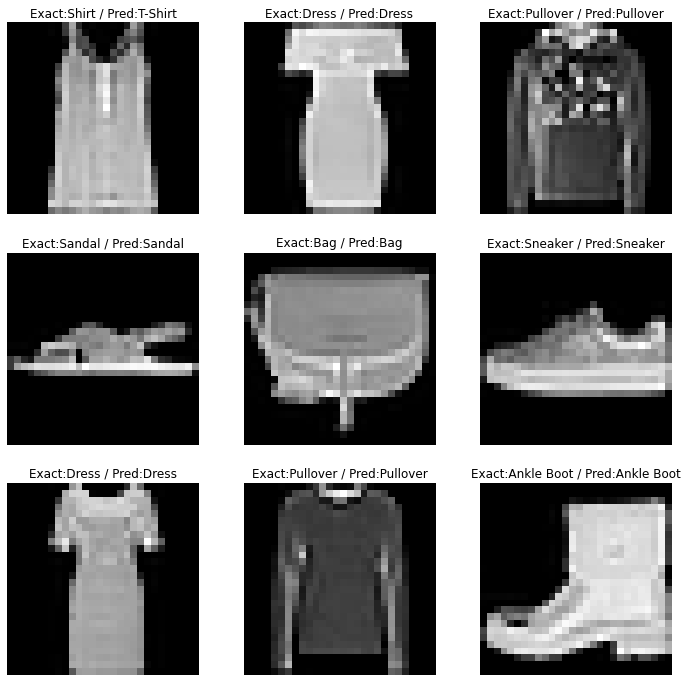

In [48]:
figure = plt.figure(figsize=(12, 12))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f"Exact:{labels_map[label]} / Pred:{labels_map[Model.prediction(img).argmax().item()]}")
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()